In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
import pyro.optim
from pyro.nn import AutoRegressiveNN
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import AffineAutoregressive, ComposeTransform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def sim_revexp_u_mgpd(n, d, a, beta, sig, gamma, MGPD=True, std=False):
    lam = np.exp(beta)
    Y = np.zeros((n, d))
    C = 1 / np.min(lam)
    k = 0

    while k < n:
        U = np.random.uniform(0, 1, d)
        W = (U ** a) / lam
        R = np.random.uniform(0, C)
        Ind = R < np.max(W)
        
        if Ind:
            Y[k, :] = W / R
            k += 1

    if std and not MGPD:
        return np.log(Y)

    X = []
    for j in range(d):
        if gamma[j] != 0:
            X.append(sig[j] * (Y[:, j] ** gamma[j] - 1) / gamma[j])
        else:
            X.append(sig[j] * np.log(Y[:, j]))
    X = np.column_stack(X)

    if MGPD and not std:
        return X
    if std and MGPD:
        return {'X': X, 'Z': np.log(Y)}

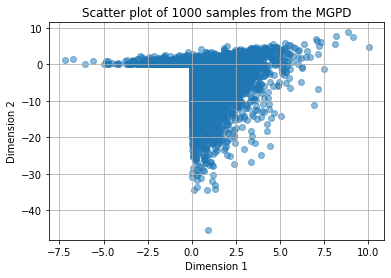

In [3]:
n_samples = 10000
d = 2
a = np.array([1, 5])
beta = np.array([0, 0])
sig = np.array([1.0, 1])
gamma = np.array([0, 0])

samples = sim_revexp_u_mgpd(n_samples, d, a, beta, sig, gamma)

# Visualize the samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot of 1000 samples from the MGPD')
# plt.xlim([-5, 10]) 
# plt.ylim([-5,10])
plt.grid(True)
plt.show()

In [4]:
dim = 2
base_dist = dist.MultivariateNormal(torch.zeros(dim,device=device), torch.eye(dim,device=device))

# Define the number of flow steps
num_flows = 5

# Define the flows
flows = []
for _ in range(num_flows):
    # Define an autoregressive neural network
    arn = AutoRegressiveNN(dim, [50,50]).to(device) 
    # Define the affine autoregressive flow
    flow = AffineAutoregressive(arn).to(device) 
    flows.append(flow)

# Wrap flows in an nn.ModuleList and define the model
class NormalizingFlowModel(torch.nn.Module):
    def __init__(self, base_dist, transforms):
        super(NormalizingFlowModel, self).__init__()
        self.base_dist = base_dist
        self.transforms = torch.nn.ModuleList(transforms)
        self.transform = ComposeTransform(self.transforms)
        self.flow_dist = dist.TransformedDistribution(self.base_dist, self.transform)
    
    def log_prob(self, x):
        return self.flow_dist.log_prob(x)
    
    def forward(self, x):
        return self.flow_dist.log_prob(x)
    
    def sample(self, sample_shape=torch.Size()):
        return self.flow_dist.sample(sample_shape)


def log_mean_exp(x, dim=0):
    """
    Computes log( mean( exp(x), dim ) ) in a numerically stable way.
    
    Args:
        x:   A PyTorch tensor.
        dim: The dimension along which to average.
    Returns:
        A tensor of shape x reduced along `dim`.
    """
    # 1) Find max along `dim`
    x_max, _ = torch.max(x, dim=dim, keepdim=True)

    # 2) Shift and exponentiate
    shifted_exp = torch.exp(x - x_max)

    # 3) Average, then take log
    mean_shifted_exp = torch.mean(shifted_exp, dim=dim, keepdim=True)
    log_mean_shifted_exp = torch.log(mean_shifted_exp)

    # 4) Add the max back
    out = x_max + log_mean_shifted_exp

    # 5) Squeeze back down if needed
    return out.squeeze(dim)

# Define the transformed distribution
f_U_model = NormalizingFlowModel(base_dist, flows).to(device)

num_U_samples = 100000
U_samples = f_U_model.sample((num_U_samples,))
max_U = torch.max(U_samples, dim=1)[0]
E_exp_max_U = torch.mean(torch.exp(max_U)).item()
print(f"E[exp(max(U))] ≈ {E_exp_max_U}")

E[exp(max(U))] ≈ 2.179234266281128


In [5]:
data = torch.tensor(samples, dtype=torch.float, device=device)


Iteration 0, Loss: 5.924866676330566
Epoch 0 - Learning Rate: 0.0005


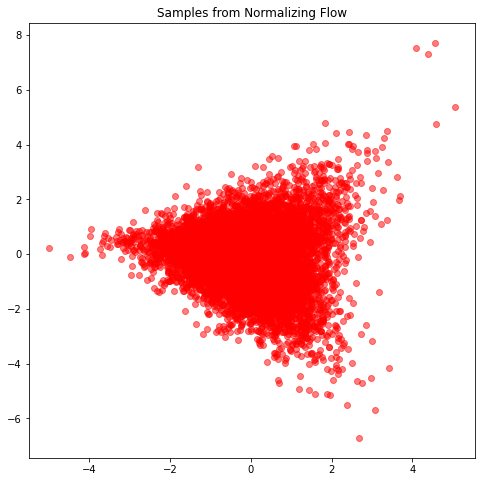

Iteration 100, Loss: 2159.0458984375
Epoch 100 - Learning Rate: 0.0005


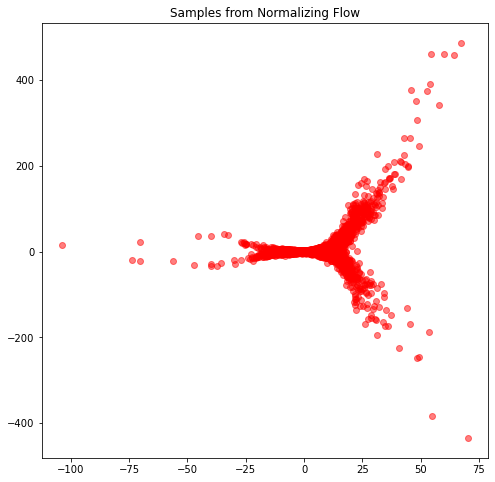

Iteration 200, Loss: 22.357311248779297
Epoch 200 - Learning Rate: 0.0005


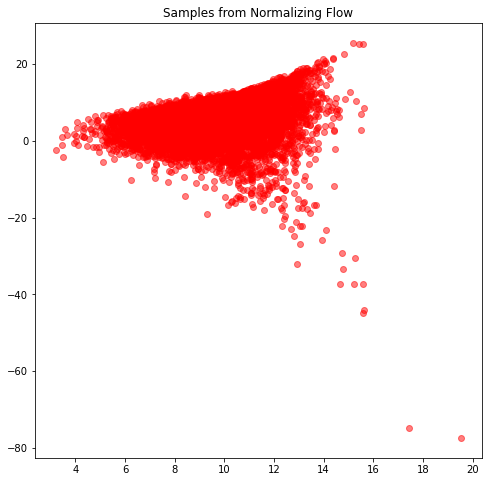

KeyboardInterrupt: 

In [7]:
optimizer = torch.optim.Adam(f_U_model.parameters(),  lr=5e-4,weight_decay=1e-5)
batch_size = 256
num_iterations = 2000
num_U_samples = 1000000
loss_history = []
show_iter = 100

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_iterations)

# Integration settings
s_min = -10.0
s_max = 10.0
num_integration_points = 10000
s_values = torch.linspace(s_min, s_max, num_integration_points,device=device)  # Shape (num_points, 1, 1)
s_values = s_values.reshape(-1, 1, 1)

for it in range(num_iterations):
    # Sample a batch of data from h_U
    idx = np.random.choice(data.shape[0], batch_size, replace=False)
    batch_x = data[idx]  # Shape (batch_size, dim)
    
    # Expand batch_x to match s_values
    x_expanded = batch_x.unsqueeze(0)  # Shape (1, effective_batch_size, dim)
    x_expanded = x_expanded.expand(num_integration_points, -1, -1)  # Shape (num_points, effective_batch_size, dim)
    
    # Expand s_values to match batch size and dimension
    s_expanded = s_values.to(batch_x.device)  # Shape (num_points, 1, 1)

    s_expanded = s_expanded.expand(-1, batch_size, 1)  # Shape (num_points, effective_batch_size, 1)

    # Compute x + s for all s_values
    x_plus_s = x_expanded + s_expanded  # Broadcasting over the last dimension
    # x_plus_s shape: (num_points, effective_batch_size, dim)
    x_plus_s = x_plus_s.reshape(-1, dim)  # Flatten to (num_points * effective_batch_size, dim)

    # Compute f_U(x + s)
    log_f_U = f_U_model.log_prob(x_plus_s)  # Shape (num_points * effective_batch_size,)
    
    # Corrected reshaping using the effective batch size
#     f_U_x_s = torch.exp(log_f_U).reshape(num_integration_points, batch_size)  # Shape (num_points, effective_batch_size)
    
    #####################################################################################
#     # Compute the integrand f_U(x + s) * exp(s)
#     exp_s = torch.exp(s_values.squeeze(-1)).to(batch_x.device)  # Shape (num_points, 1)
#     integrand = f_U_x_s * exp_s  # Broadcasting over effective_batch_size
    
#     # Compute the integral using the trapezoidal rule
#     delta_s = (s_max - s_min) / (num_integration_points - 1)
#     integral = torch.trapz(integrand, dx=delta_s, dim=0)  # Shape (effective_batch_size,)
    #######################################################################################
    # log_integrand.shape = (num_points, batch_size)
    # Each element is [log f_U(x+s) + s]
    log_integrand = log_f_U.reshape(num_integration_points, batch_size) + s_values.reshape(num_integration_points,1)
    # We want to numerically approximate log( ∫ exp(log_integrand) ds ).
    # The trapezoid rule in log-space can be approximated by log-sum-exp:

    # 1. log-sum-exp over 'num_points' dimension
    max_vals, _ = torch.max(log_integrand, dim=0, keepdim=True)  # shape (1, batch_size)
    stable_exp = torch.exp(log_integrand - max_vals)             # shape (num_points, batch_size)
    delta_s = (s_max - s_min) / (num_integration_points - 1)
    sum_exp = torch.trapz(stable_exp, dx=delta_s, dim=0)         # shape (batch_size,)
    # 2. Now put the max_vals back in:
    log_integral = max_vals.squeeze(0) + torch.log(sum_exp + 1e-40)  # shape (batch_size,)
#     print(log_integral.shape)
    ########################################################################################
    U_samples = f_U_model.sample((num_U_samples,)).to(device)
    max_U = torch.max(U_samples, dim=1)[0]
    
    log_E_exp_max_U = log_mean_exp(max_U, dim=0)
    
    ########################################################################################
#     # Compute h_U(x)
#     h_U_x = (1 / E_exp_max_U) * integral
    
#     # Avoid log of zero
#     h_U_x = torch.clamp(h_U_x, min=1e-12)
#     # Compute the negative log-likelihood loss
#     loss = -torch.log(h_U_x)
    ########################################################################################
    loss = -log_integral + log_E_exp_max_U
    
    ########################################################################################


    batch_loss = loss.mean()
    
    # Backpropagation
    optimizer.zero_grad()
    batch_loss.backward()
    for name, param in f_U_model.named_parameters():
        if param.grad is None:
            print(name, "grad is None")
    optimizer.step()
    
    # Record loss
    loss_history.append(batch_loss.item())
    
    if it % 100 == 0:
        print(f"Iteration {it}, Loss: {batch_loss.item()}")
        current_lr = optimizer.param_groups[0]['lr']
    
        print(f"Epoch {it} - Learning Rate: {current_lr}")
        # Debugging: Print shapes
        
    if it % show_iter == 0:
        samples = f_U_model.sample((n_samples,))

        plt.figure(figsize=(8,8))
        plt.scatter(samples[:,0].cpu().numpy(), samples[:,1].cpu().numpy(), alpha=0.5, color='red')
        plt.title('Samples from Normalizing Flow')
        plt.show()

#     scheduler.step()
    
# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

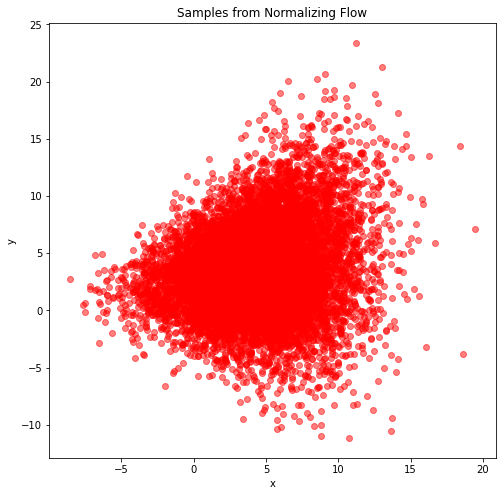

In [10]:
with torch.no_grad():
    samples = f_U_model.sample((10000,))

# Plot the samples from the flow
plt.figure(figsize=(8,8))
plt.scatter(samples[:,0].cpu().numpy(), samples[:,1].cpu().numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

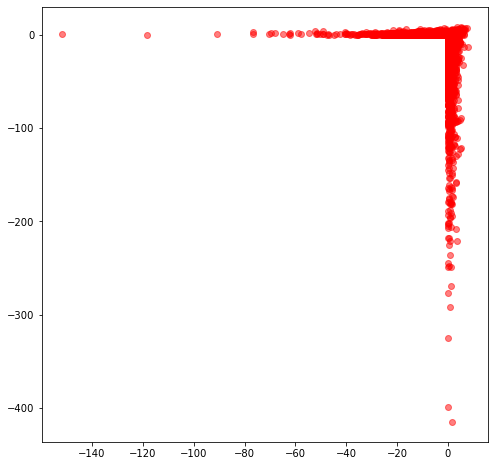

In [22]:
T = samples
T_max = torch.max(samples,axis=1,keepdim=True)[0]
T1 = T-T_max
E = torch.empty(n_samples)
E = E.exponential_(1.0).unsqueeze(1)
Pred = E + T1
plt.figure(figsize=(8,8))
plt.scatter(Pred[:,0].numpy(), Pred[:,1].numpy(), alpha=0.5, color='red')

In [8]:
batch_size = 2
idx = np.random.choice(data.shape[0], batch_size, replace=False)
num_integration_points = 5
batch_x = data[idx]  # Shape (batch_size, dim)
batch_x = torch.tensor([[1,2],[-3,4]])
print(batch_x)
# Expand batch_x to match s_values
x_expanded = batch_x.unsqueeze(0)  # Shape (1, effective_batch_size, dim)

x_expanded = x_expanded.expand(num_integration_points, -1, -1)  # Shape (num_points, effective_batch_size, dim)
print(x_expanded)

tensor([[ 1,  2],
        [-3,  4]])
tensor([[[ 1,  2],
         [-3,  4]],

        [[ 1,  2],
         [-3,  4]],

        [[ 1,  2],
         [-3,  4]],

        [[ 1,  2],
         [-3,  4]],

        [[ 1,  2],
         [-3,  4]]])


In [9]:
# Expand s_values to match batch size and dimension
s_values = torch.linspace(s_min, s_max, num_integration_points).reshape(-1, 1, 1)  # Shape (num_points, 1, 1)
s_expanded = s_values.to(batch_x.device)  # Shape (num_points, 1, 1)
print(s_expanded)
s_expanded = s_expanded.expand(-1, batch_size, 1)  # Shape (num_points, effective_batch_size, 1)
print(s_expanded)

tensor([[[-10.]],

        [[ -5.]],

        [[  0.]],

        [[  5.]],

        [[ 10.]]])
tensor([[[-10.],
         [-10.]],

        [[ -5.],
         [ -5.]],

        [[  0.],
         [  0.]],

        [[  5.],
         [  5.]],

        [[ 10.],
         [ 10.]]])


In [10]:

# Compute x + s for all s_values
x_plus_s = x_expanded + s_expanded  # Broadcasting over the last dimension
print(x_plus_s.shape)
print(x_plus_s)
# x_plus_s shape: (num_points, effective_batch_size, dim)
x_plus_s = x_plus_s.reshape(-1, dim)  # Flatten to (num_points * effective_batch_size, dim)
print(x_plus_s.shape)
print(x_plus_s)

torch.Size([5, 2, 2])
tensor([[[ -9.,  -8.],
         [-13.,  -6.]],

        [[ -4.,  -3.],
         [ -8.,  -1.]],

        [[  1.,   2.],
         [ -3.,   4.]],

        [[  6.,   7.],
         [  2.,   9.]],

        [[ 11.,  12.],
         [  7.,  14.]]])
torch.Size([10, 2])
tensor([[ -9.,  -8.],
        [-13.,  -6.],
        [ -4.,  -3.],
        [ -8.,  -1.],
        [  1.,   2.],
        [ -3.,   4.],
        [  6.,   7.],
        [  2.,   9.],
        [ 11.,  12.],
        [  7.,  14.]])


In [11]:
log_f_U = f_U_model.log_prob(x_plus_s)
log_f_U

tensor([ -52.0577,  -58.9335,  -12.2347,  -27.1714,   -6.0811,  -17.7032,
         -63.2901,  -73.8858, -187.1102, -191.7266], grad_fn=<AddBackward0>)

In [12]:
f_U_x_s = log_f_U.reshape(num_integration_points, batch_size)  # Shape (num_points, effective_batch_size)
f_U_x_s

tensor([[ -52.0577,  -58.9335],
        [ -12.2347,  -27.1714],
        [  -6.0811,  -17.7032],
        [ -63.2901,  -73.8858],
        [-187.1102, -191.7266]], grad_fn=<ViewBackward0>)

In [13]:
s_values.reshape(num_integration_points,1).shape

torch.Size([5, 1])

In [14]:
log_integrand = log_f_U.reshape(num_integration_points, batch_size) + s_values.reshape(num_integration_points,1)
print(log_integrand.shape)
log_integrand

torch.Size([5, 2])


tensor([[ -62.0577,  -68.9335],
        [ -17.2347,  -32.1714],
        [  -6.0811,  -17.7032],
        [ -58.2901,  -68.8858],
        [-177.1102, -181.7266]], grad_fn=<AddBackward0>)

In [15]:
max_vals, _ = torch.max(log_integrand, dim=0, keepdim=True)  # shape (1, batch_size)
print(max_vals.shape)
print(max_vals)
stable_exp = torch.exp(log_integrand - max_vals)    
print(stable_exp.shape)
print(stable_exp)

torch.Size([1, 2])
tensor([[ -6.0811, -17.7032]], grad_fn=<MaxBackward0>)
torch.Size([5, 2])
tensor([[4.8941e-25, 5.6359e-23],
        [1.4324e-05, 5.2064e-07],
        [1.0000e+00, 1.0000e+00],
        [2.1179e-23, 5.9110e-23],
        [0.0000e+00, 0.0000e+00]], grad_fn=<ExpBackward0>)


In [18]:
           # shape (num_points, batch_size)
delta_s = (s_max - s_min) / (num_integration_points - 1)
sum_exp = torch.trapz(stable_exp, dx=delta_s, dim=0)         # shape (batch_size,)

print(sum_exp.shape)
print(sum_exp)

torch.Size([2])
tensor([5.0001, 5.0000], grad_fn=<MulBackward1>)


In [82]:
(s_max - s_min) / (num_integration_points - 1)

5.0

In [90]:
max_vals.squeeze(0)

tensor([-8.9474, -9.2353], grad_fn=<SqueezeBackward1>)

In [17]:
# 2. Now put the max_vals back in:
log_integral = max_vals.squeeze(0) + torch.log(sum_exp + 1e-40)  # shape (batch_size,)
print(log_integral.shape)
print(log_integral)

torch.Size([2])
tensor([ -4.4717, -16.0938], grad_fn=<AddBackward0>)


In [14]:
?torch.optim.lr_scheduler.CosineAnnealingLR